# Accessing Historic Observation Data Platform data

You can easily access the finalized cloud-optimized data using the Python library `intake`, which interfaces with our data catalog. This notebook demonstrates how to interact with the data catalog to download data, along with some simple plotting code to generate figures of the data. 

In [1]:
import intake 

First, open the catalog using `intake`

In [2]:
cat = intake.open_esm_datastore("https://cadcat.s3.amazonaws.com/histwxstns/era-hdp-collection.json")

Next, view the catalog in table format. You can inspect the first few rows by calling `.head()` on the table.

In [3]:
# Access catalog as dataframe and inspect the first few rows
cat_df = cat.df
cat_df

,network_id,station_id,path
0,ASOSAWOS,ASOSAWOS_69007093217,s3://cadcat/histwxstns/ASOSAWOS/ASOSAWOS_69007...
1,ASOSAWOS,ASOSAWOS_72012200114,s3://cadcat/histwxstns/ASOSAWOS/ASOSAWOS_72012...
2,ASOSAWOS,ASOSAWOS_72019300117,s3://cadcat/histwxstns/ASOSAWOS/ASOSAWOS_72019...
3,ASOSAWOS,ASOSAWOS_72020200118,s3://cadcat/histwxstns/ASOSAWOS/ASOSAWOS_72020...
4,ASOSAWOS,ASOSAWOS_72025400119,s3://cadcat/histwxstns/ASOSAWOS/ASOSAWOS_72025...
...,...,...,...
14977,VCAPCD,VCAPCD_OJ,s3://cadcat/histwxstns/VCAPCD/VCAPCD_OJ.zarr/
14978,VCAPCD,VCAPCD_PU,s3://cadcat/histwxstns/VCAPCD/VCAPCD_PU.zarr/
14979,VCAPCD,VCAPCD_SU,s3://cadcat/histwxstns/VCAPCD/VCAPCD_SU.zarr/
14980,VCAPCD,VCAPCD_SV,s3://cadcat/histwxstns/VCAPCD/VCAPCD_SV.zarr/


View all the weather station networks by using the following code 

In [4]:
# See all network options 
cat_df["network_id"].unique()

<ArrowExtensionArray>
[   'ASOSAWOS',     'CAHYDRO',        'CDEC',       'CIMIS',       'CNRFC',
         'CRN',        'CW3E',        'CWOP',        'HADS',      'HNXWFO',
      'HOLFUY',      'HPWREN',      'LOXWFO',         'MAP',    'MARITIME',
      'MTRWFO',      'NCAWOS',        'NDBC',   'NOS-NWLON',   'NOS-PORTS',
    'OtherISD',        'RAWS',        'SCAN',      'SGXWFO',    'SHASAVAL',
      'SNOTEL', 'VALLEYWATER',      'VCAPCD']
Length: 28, dtype: large_string[pyarrow]

You can also filter the catalog to see all stations within a network

In [5]:
my_network = "ASOSAWOS"
cat_df[cat_df["network_id"] == my_network]

,network_id,station_id,path
0,ASOSAWOS,ASOSAWOS_69007093217,s3://cadcat/histwxstns/ASOSAWOS/ASOSAWOS_69007...
1,ASOSAWOS,ASOSAWOS_72012200114,s3://cadcat/histwxstns/ASOSAWOS/ASOSAWOS_72012...
2,ASOSAWOS,ASOSAWOS_72019300117,s3://cadcat/histwxstns/ASOSAWOS/ASOSAWOS_72019...
3,ASOSAWOS,ASOSAWOS_72020200118,s3://cadcat/histwxstns/ASOSAWOS/ASOSAWOS_72020...
4,ASOSAWOS,ASOSAWOS_72025400119,s3://cadcat/histwxstns/ASOSAWOS/ASOSAWOS_72025...
...,...,...,...
421,ASOSAWOS,ASOSAWOS_A0002694297,s3://cadcat/histwxstns/ASOSAWOS/ASOSAWOS_A0002...
422,ASOSAWOS,ASOSAWOS_A0002804116,s3://cadcat/histwxstns/ASOSAWOS/ASOSAWOS_A0002...
423,ASOSAWOS,ASOSAWOS_A0685400115,s3://cadcat/histwxstns/ASOSAWOS/ASOSAWOS_A0685...
424,ASOSAWOS,ASOSAWOS_A0704900320,s3://cadcat/histwxstns/ASOSAWOS/ASOSAWOS_A0704...


You can subset the catalog and read in the cloud-optimized data as `xarray.Dataset` objects using the method shown below. To change the data downloaded, simply modify the inputs in the dictionary `query`. These inputs must correspond to valid options in the catalog. 

In [6]:
# Set your query here
query = {
    "network_id": "ASOSAWOS",  # Name of the network
    "station_id": ["ASOSAWOS_A0002694297","ASOSAWOS_A0704900320","ASOSAWOS_72020200118"] # List of stations to get data for 
}

# Subset catalog
cat_subset = cat.search(**query)

# View the data you've selected before downloading
cat_subset.df

,network_id,station_id,path
0,ASOSAWOS,ASOSAWOS_72020200118,s3://cadcat/histwxstns/ASOSAWOS/ASOSAWOS_72020...
1,ASOSAWOS,ASOSAWOS_A0002694297,s3://cadcat/histwxstns/ASOSAWOS/ASOSAWOS_A0002...
2,ASOSAWOS,ASOSAWOS_A0704900320,s3://cadcat/histwxstns/ASOSAWOS/ASOSAWOS_A0704...


In [7]:
cat_subset

,unique
network_id,1
station_id,3
path,3
derived_station_id,0


Then, you can download all the files. The files will be downloaded as a dictionary, in which each key is a string description of the data, and the item is the data object. 

In [8]:
# Get dataset dictionary 
dsets = cat_subset.to_dataset_dict(
    xarray_open_kwargs={'consolidated':False},
    storage_options={'anon':True}
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'network_id.station_id'


To see all the string IDs for the Datasets in the dictionary, you can print them with the following code: 

In [9]:
list(dsets.keys())

['ASOSAWOS.ASOSAWOS_A0704900320',
 'ASOSAWOS.ASOSAWOS_A0002694297',
 'ASOSAWOS.ASOSAWOS_72020200118']

You can easily access the files in the dictionary using the following format: 
```
dsets[<string ID of data>]
```
The string ID of the data is constructed using both the network ID and the station ID for each individual weather station. 

In [10]:
# Retrieve a single file
ds = dsets["ASOSAWOS.ASOSAWOS_72020200118"]
ds

<xarray.Dataset> Size: 28MB
Dimensions:             (station: 1, time: 154781)
Coordinates:
  * station             (station) object 8B 'ASOSAWOS_72020200118'
  * time                (time) datetime64[ns] 1MB 2005-01-03T19:00:00 ... 202...
Data variables: (12/22)
    elevation           (station, time) float64 1MB dask.array<chunksize=(1, 154781), meta=np.ndarray>
    elevation_eraqc     (station, time) float64 1MB dask.array<chunksize=(1, 154781), meta=np.ndarray>
    hurs_derived        (station, time) float64 1MB dask.array<chunksize=(1, 154781), meta=np.ndarray>
    hurs_derived_eraqc  (station, time) float64 1MB dask.array<chunksize=(1, 154781), meta=np.ndarray>
    lat                 (station, time) float64 1MB dask.array<chunksize=(1, 154781), meta=np.ndarray>
    lon                 (station, time) float64 1MB dask.array<chunksize=(1, 154781), meta=np.ndarray>
    ...                  ...
    sfcWind_dir_eraqc   (station, time) float64 1MB dask.array<chunksize=(1, 154781), meta=np.ndarray>
    sfcWind_eraqc       (station, time) float64 1MB dask.array<chunksize=(1, 154781), meta=np.ndarray>
    tas                 (station, time) float64 1MB dask.array<chunksize=(1, 154781), meta=np.ndarray>
    tas_eraqc           (station, time) float64 1MB dask.array<chunksize=(1, 154781), meta=np.ndarray>
    tdps                (station, time) float64 1MB dask.array<chunksize=(1, 154781), meta=np.ndarray>
    tdps_eraqc          (station, time) float64 1MB dask.array<chunksize=(1, 154781), meta=np.ndarray>
Attributes: (12/25)
    CALL:                            TMK
    DOI:                             https://doi.org/10.5281/zenodo.16370140
    ICAO:                            KTMK
    Networks:                        AWOS
    USAF:                            720202
    WBAN:                            118
    ...                              ...
    intake_esm_vars:                 ['ASOSAWOS_72020200118']
    intake_esm_attrs:network_id:     ASOSAWOS
    intake_esm_attrs:station_id:     ASOSAWOS_72020200118
    intake_esm_attrs:path:           s3://cadcat/histwxstns/ASOSAWOS/ASOSAWOS...
    intake_esm_attrs:_data_format_:  zarr
    intake_esm_dataset_key:          ASOSAWOS.ASOSAWOS_72020200118

## Make a quick plot of the data 
`xarray` has some nice mapping features that enable you to quickly generate a plot for a single timestep. This lets you get a sense for the data you read in. 

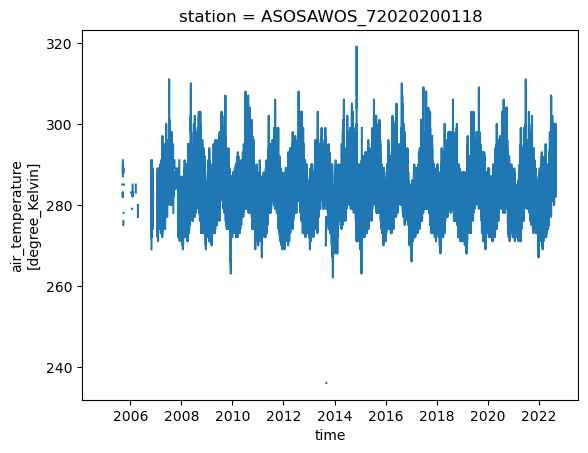

In [11]:
variable_to_plot = "tas"
ds.squeeze()[variable_to_plot].plot(x="time");

# Subset the historical weather stations for a region

If you're interested in historical weather observation stations in a specific area, you can also subset the full archive of stations to identify those that you are interested in. We will read in the Historical Data Platform station list, which provides the coordinates, dates of coverage, source network, and total number of observations for each station. We'll soon be adding additional information like the state and common station identifiers!

For this, we'll use an area shapefile; upload your own to see which stations are in your area! You can pass either a **web link to an open access shapefile**, or **upload your own shapefile** to your Hub instance too.

In [19]:
# Read in the Historical Data Platform station list
import geopandas as gpd
import pandas as pd
import sys
import os
import rioxarray as rio

# Set relative paths to other folders and objects in repository.
BUCKET_NAME = "wecc-historical-wx"
RAW_DIR = "1_raw_wx"
CLEAN_DIR = "2_clean_wx"
QAQC_DIR = "3_qaqc_wx"
MERGE_DIR = "4_merge_wx"

# Import qaqc stage plot functions
sys.path.append(os.path.abspath("../notebooks"))
from figure_utils import clip_to_shapefile


hdp_stns = pd.read_csv(
    f"s3://{BUCKET_NAME}/{MERGE_DIR}/all_network_stationlist_merge.csv"
)

In [20]:
roi = gpd.read_file(
    "s3://wecc-historical-wx/0_maps/ca_counties/CA_Counties.shp"
)
roi = roi[roi["NAME"] == "Sacramento"]

In [21]:
roi.explore()

In [22]:
# Region of Interest shapefile, and set coordinate reference system
#roi = gpd.read_file("...")  # Replace this with your own shapefile!
roi = roi.to_crs("EPSG:3857")

# If there are multiple polygons within the shapefile and you want to further subset, you will need to do so.
# Example
# roi = roi[roi["NAME"] == "SPECIFIC_AREA"]

In [24]:
import rioxarray as rio

In [26]:
hdp_stns.crs

AttributeError: 'DataFrame' object has no attribute 'crs'

In [16]:
# Clip the stationlist to subset within your area of interest
stns_within_area = clip_to_shapefile(hdp_stns, roi)

AttributeError: 'DataFrame' object has no attribute 'rio'

This subset are the stations within the designated area from your submitted shapefile! You can easily export this list now for your own information, and use it to look up specific stations.

In [1]:
# Export the subset portion of station list
stns_within_area.to_csv("subset_station_list.csv")

NameError: name 'stns_within_area' is not defined

Want a more interactive way to zoom in on an area? use stns.explore()! Note, it may take some time to load.

In [ ]:
stns_within_area.explore()

AttributeError: 'DataFrame' object has no attribute 'explore'